# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import shutil
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import logging
from datetime import datetime
import yaml
import json
import csv
from zoneinfo import ZoneInfo
import pandas as pd
import seaborn as sns
from abc import ABC, abstractmethod

Mounted at /content/drive


# An Algorithm to split data into Train/Validation/Test

In [2]:
class BaseSplitter(ABC):
  def __init__(self, interim_dataset_path, processed_dataset_path, lookfor):
    self.interim_dataset_path = interim_dataset_path
    self.processed_dataset_path = processed_dataset_path
    self.source_folders = [os.path.join(self.interim_dataset_path, f)
      for f in os.listdir(self.interim_dataset_path)
      if os.path.isdir(os.path.join(self.interim_dataset_path, f))]
    self.source_word = lookfor
    self.labels = ["train", "val", "test"]
    self.df = None

  def __repr__(self):
    return f"{self.__class__.__name__}(source='{self.interim_dataset_path}')"

  def make_directory(self, base_path, subfolder):
    out_folder = os.path.join(base_path, subfolder)
    os.makedirs(out_folder, exist_ok=True)
    return out_folder

  @abstractmethod
  def split(self):
    pass

  def _calculate_summary(self):
    train_path = os.path.join(self.processed_dataset_path, self.labels[0])
    val_path = os.path.join(self.processed_dataset_path, self.labels[1])
    test_path = os.path.join(self.processed_dataset_path, self.labels[2])

    classes = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]

    train_count = [len(list(Path(os.path.join(train_path, source_path)).glob("*"))) for source_path in classes]
    val_count = [len(list(Path(os.path.join(val_path, source_path)).glob("*"))) for source_path in classes]
    test_count = [len(list(Path(os.path.join(test_path, source_path)).glob("*"))) for source_path in classes]

    values = {}

    for i, class_ in enumerate(classes):
      values[class_] = [train_count[i], val_count[i], test_count[i]]

    self.df = pd.DataFrame(values, index=self.labels)

  @property
  def df_pct(self):
    return (self.df.div(self.df.sum(axis=1), axis=0) * 100)

  def show_plots(self, kind):
    if self.df is None:
      raise RuntimeError("Run split() before plotting.")

    match kind:
      case "stacked_counts":
        self.df.plot(kind='bar', stacked=True, rot=0)
        plt.ylabel("Number of samples")
        plt.title("Class distribution per dataset split")
        plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

      case "stacked_percent":
        self.df_pct.plot(kind='bar', stacked=True, rot=0)
        plt.ylabel("Percentage (%)")
        plt.title("Class distribution across splits (percentages)")
        plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

      case "per_class_comparison":
        self.df.T.plot(kind='bar', rot=0)
        plt.ylabel("Count")
        plt.title("Split comparison per class")
        plt.legend(title="Split", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

      case "pie_chart":
        fig, axes = plt.subplots(1, len(self.labels), figsize=(8, 4))
        for ax, label in zip(axes, self.labels):
          self.df.loc[label].plot(kind="pie", autopct="%1.1f%%", ax=ax, ylabel="")
          ax.set_title(f"{label.capitalize()} set class distribution")

        plt.tight_layout()
        plt.show()

      case "heatmap":
        plt.figure(figsize=(8,6))
        sns.heatmap(self.df_pct, annot=True, fmt=".1f", cmap="YlGnBu")
        plt.title("Class distribution (%) across splits")
        plt.ylabel("Split")
        plt.xlabel("Class")
        plt.show()

      case _:
        raise ValueError("Invalid plot type. Choose from: stacked_counts, stacked_percent, per_class_comparison, pie_chart, heatmap")

  def show_summary(self):
    if self.df is None:
      raise RuntimeError("Run split() before plotting.")

    summary = self.df.copy()
    summary_pct = self.df_pct.round(1)

    summary.columns = [c + " (count)" for c in summary.columns]
    summary_pct.columns = [c + " (%)" for c in summary_pct.columns]

    final_table = pd.concat([summary, summary_pct], axis=1)
    return final_table

In [3]:
class ClassificationSplitter(BaseSplitter):
  def __init__(self, interim_dataset_path, processed_dataset_path, lookfor):
    super().__init__(interim_dataset_path, processed_dataset_path, lookfor)

  def copy_images(self, folder, images):
    for image in tqdm(images):
      shutil.copy2(image, folder)

  def split(self, train_ratio, val_ratio, seed=42):
    if train_ratio + val_ratio > 1:
      raise ValueError("train_ratio + val_ratio must be <= 1")

    rng = np.random.default_rng(seed)

    train_folder = self.make_directory(self.processed_dataset_path, self.labels[0])
    val_folder = self.make_directory(self.processed_dataset_path, self.labels[1])
    test_folder = self.make_directory(self.processed_dataset_path, self.labels[2])

    for source in self.source_folders:
      source_path = Path(source) / self.source_word
      print(f"Processing from: {source_path}")

      base_name = os.path.basename(source)

      images = np.array(list(source_path.glob("*.*")))

      if len(images) == 0:
        raise RuntimeError(f"No images found in {source_path}")

      rng.shuffle(images)

      train_count = int(images.size * train_ratio)
      val_count = int(images.size * val_ratio)

      train_out_folder = self.make_directory(train_folder, base_name)
      val_out_folder = self.make_directory(val_folder, base_name)
      test_out_folder = self.make_directory(test_folder, base_name)

      print(f"Outputting to: {train_out_folder}")
      print(f"Outputting to: {val_out_folder}")
      print(f"Outputting to: {test_out_folder}")

      # self.copy_images(train_out_folder, images[:train_count])
      # self.copy_images(val_out_folder, images[train_count:train_count+val_count])
      # self.copy_images(test_out_folder, images[train_count+val_count:])

    self._calculate_summary()

In [4]:
class SegmentationSplitter(BaseSplitter):
  def __init__(self, interim_dataset_path, processed_dataset_path, lookfor):
    super().__init__(interim_dataset_path, processed_dataset_path, lookfor)
    self.base_name_image = "images"
    self.base_name_mask  = "mask"

  def copy_images(self, folder_images, folder_masks, pairs):
    for image, mask in tqdm(pairs):
      shutil.copy2(image, folder_images)
      shutil.copy2(mask, folder_masks)

  def split(self, train_ratio, val_ratio, seed=42):
    if train_ratio + val_ratio > 1:
      raise ValueError("train_ratio + val_ratio must be <= 1")

    rng = np.random.default_rng(seed)

    train_folder = self.make_directory(self.processed_dataset_path, self.labels[0])
    val_folder = self.make_directory(self.processed_dataset_path, self.labels[1])
    test_folder = self.make_directory(self.processed_dataset_path, self.labels[2])

    image_folder = [f for f in self.source_folders if os.path.basename(f) == "images"][0]
    mask_folder  = [f for f in self.source_folders if os.path.basename(f) == "mask"][0]

    image_path = Path(image_folder) / self.source_word
    mask_path  = Path(mask_folder) / self.source_word

    if len(list(image_path.glob("*.jpg"))) == 0:
      raise RuntimeError(f"No images found in {image_path}")

    print(f"Processing from: {image_path}")

    pairs = []
    for img in image_path.glob("*.*"):
      mask = mask_path / f"{img.stem}_m{img.suffix}"
      if mask.exists():
        pairs.append((img, mask))

    rng.shuffle(pairs)

    train_count = int(len(pairs) * train_ratio)
    val_count = int(len(pairs) * val_ratio)

    train_out_folder_images = self.make_directory(train_folder, self.base_name_image)
    val_out_folder_images = self.make_directory(val_folder, self.base_name_image)
    test_out_folder_images = self.make_directory(test_folder, self.base_name_image)

    train_out_folder_masks = self.make_directory(train_folder, self.base_name_mask)
    val_out_folder_masks = self.make_directory(val_folder, self.base_name_mask)
    test_out_folder_masks = self.make_directory(test_folder, self.base_name_mask)

    print(f"Outputting to: {train_out_folder_images}")
    print(f"Outputting to: {val_out_folder_images}")
    print(f"Outputting to: {test_out_folder_images}")

    # self.copy_images(train_out_folder_images, train_out_folder_masks, pairs[:train_count])
    # self.copy_images(val_out_folder_images, val_out_folder_masks, pairs[train_count:train_count+val_count])
    # self.copy_images(test_out_folder_images, test_out_folder_masks, pairs[train_count+val_count:])

  def show_plots(self, *args, **kwargs):
    raise NotImplementedError("Plotting is not supported for segmentation datasets.")

  def show_summary(self):
    raise NotImplementedError("Summary tables are not supported for segmentation datasets.")

In [5]:
interim_mri_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri"
processed_mri_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/mri"
mri_dataset_splitter = ClassificationSplitter(interim_mri_dataset_path, processed_mri_dataset_path, lookfor="top_view")
mri_dataset_splitter.split(train_ratio=0.7, val_ratio=0.2, seed=42)

Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/glioma/top_view
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/mri/train/glioma
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/mri/val/glioma
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/mri/test/glioma
Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/meningioma/top_view
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/mri/train/meningioma
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/mri/val/meningioma
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/mri/test/meningioma
Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Proje

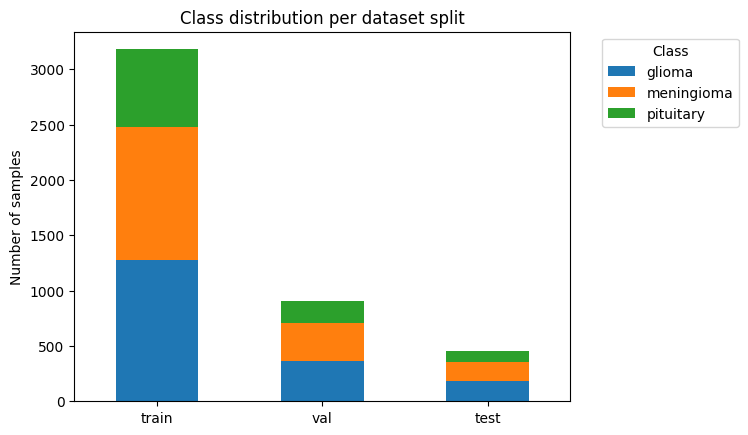

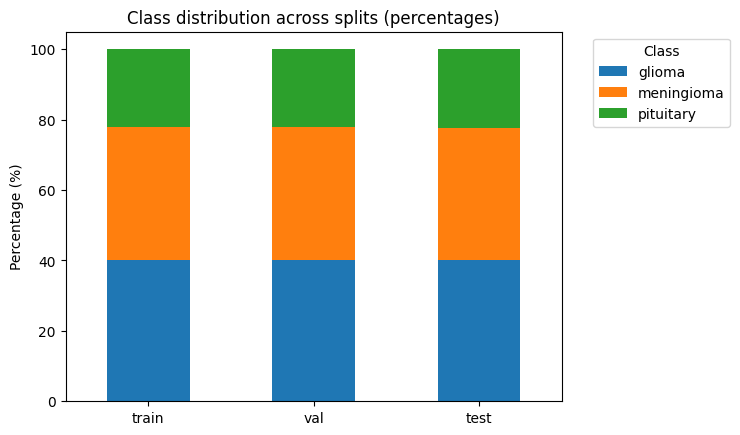

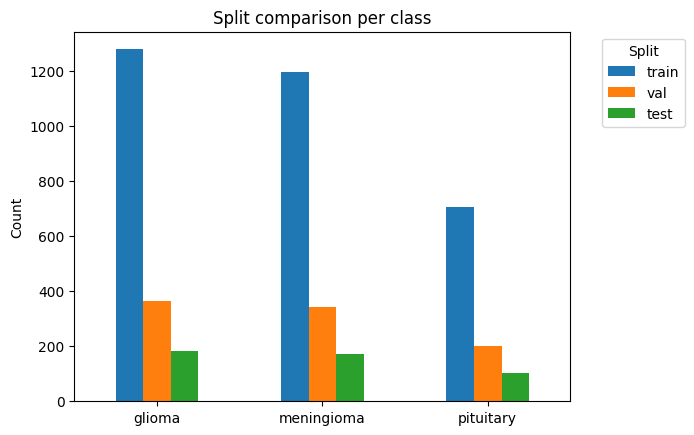

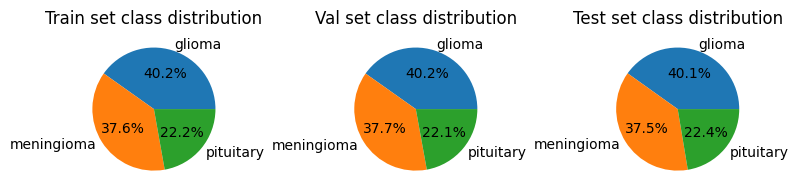

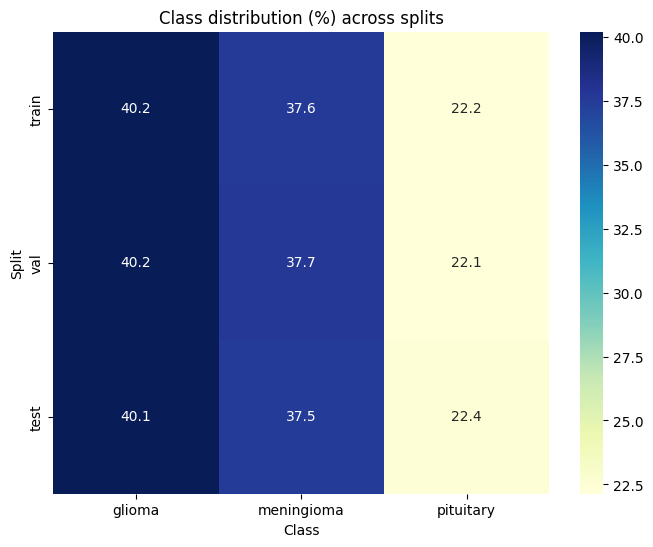

In [6]:
mri_dataset_splitter.show_plots("stacked_counts")
mri_dataset_splitter.show_plots("stacked_percent")
mri_dataset_splitter.show_plots("per_class_comparison")
mri_dataset_splitter.show_plots("pie_chart")
mri_dataset_splitter.show_plots("heatmap")

In [7]:
mri_dataset_splitter.show_summary()

,glioma (count),meningioma (count),pituitary (count),glioma (%),meningioma (%),pituitary (%)
train,1278,1197,706,40.2,37.6,22.2
val,365,342,201,40.2,37.7,22.1
test,183,171,102,40.1,37.5,22.4


In [ ]:
interim_ct_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/ct"
processed_ct_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/ct"
ct_dataset_splitter = ClassificationSplitter(interim_ct_dataset_path, processed_ct_dataset_path, lookfor="top_view")
ct_dataset_splitter.split(train_ratio=0.7, val_ratio=0.2, seed=42)

Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/ct/normal/top_view
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/ct/train/normal
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/ct/val/normal
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/ct/test/normal


100%|██████████| 162/162 [00:03<00:00, 50.04it/s]


Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/ct/tumor/top_view
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/ct/train/tumor
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/ct/val/tumor
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/ct/test/tumor


100%|██████████| 171/171 [00:04<00:00, 39.16it/s]


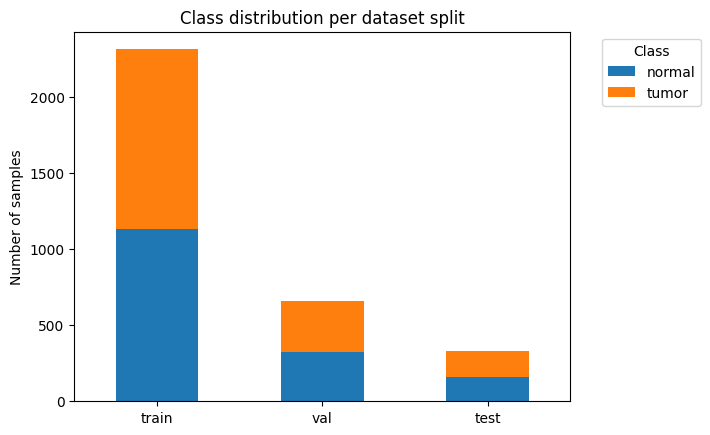

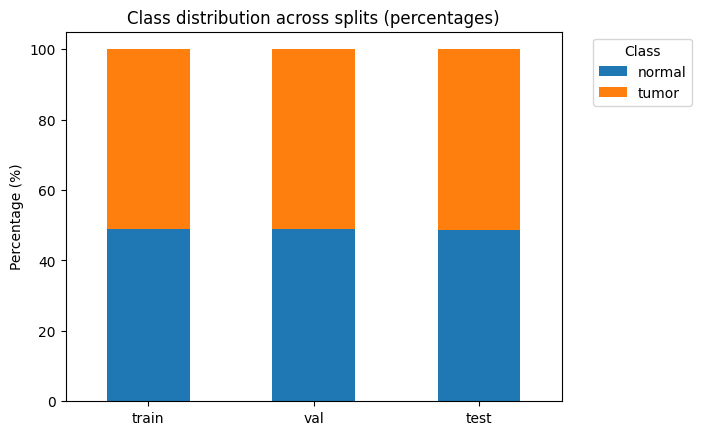

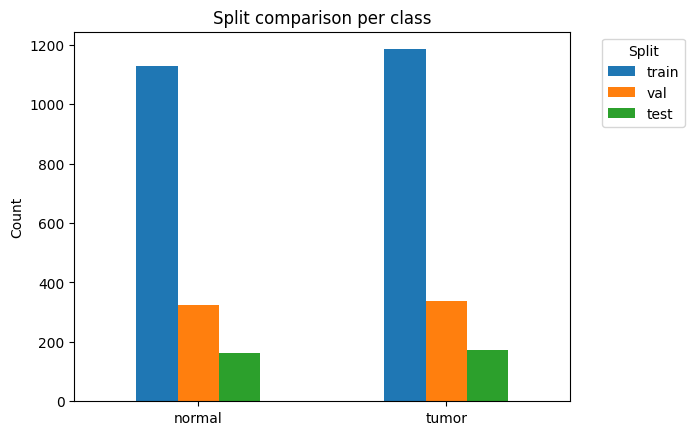

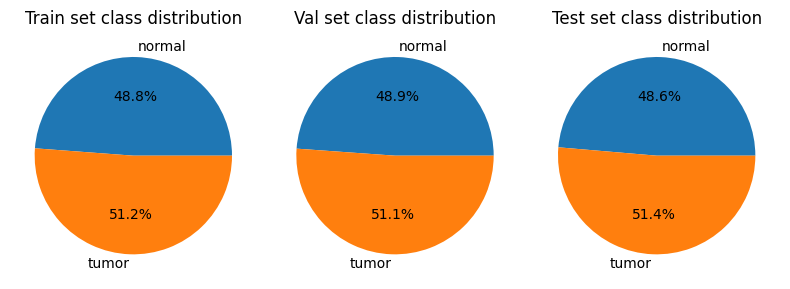

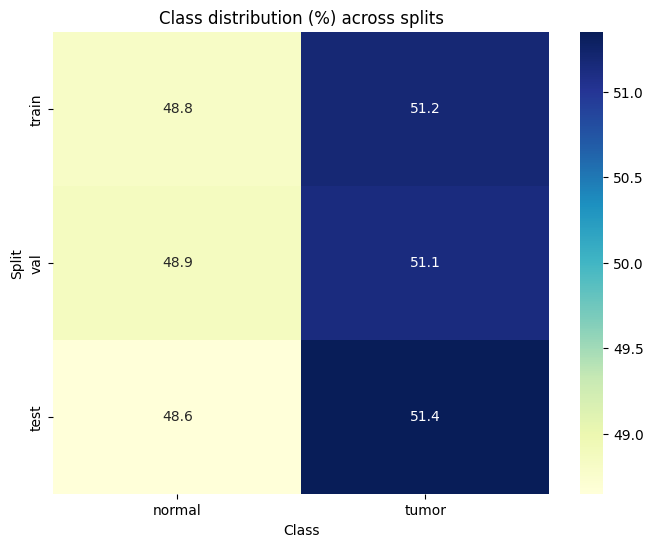

In [ ]:
ct_dataset_splitter.show_plots("stacked_counts")
ct_dataset_splitter.show_plots("stacked_percent")
ct_dataset_splitter.show_plots("per_class_comparison")
ct_dataset_splitter.show_plots("pie_chart")
ct_dataset_splitter.show_plots("heatmap")

In [ ]:
ct_dataset_splitter.show_summary()

,normal (count),tumor (count),normal (%),tumor (%)
train,1130,1185,48.8,51.2
val,323,338,48.9,51.1
test,162,171,48.6,51.4


In [ ]:
interim_segmentation_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/segmentation"
processed_segmentation_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/segmentation"
segmentation_dataset_splitter = SegmentationSplitter(interim_segmentation_dataset_path, processed_segmentation_dataset_path, lookfor="no_black")
segmentation_dataset_splitter.split(train_ratio=0.7, val_ratio=0.2, seed=42)

Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/segmentation/images/no_black
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/segmentation/train/images
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/segmentation/val/images
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/processed/segmentation/test/images


100%|██████████| 624/624 [03:21<00:00,  3.10it/s]
